In [97]:
from ambient_api.ambientapi import AmbientAPI
import numpy as np
from datetime import datetime
import time
from matplotlib import pyplot as plt
import os
import xarray as xr
import pandas as pd
import json

In [2]:
!export AMBIENT_ENDPOINT=https://api.ambientweather.net/v1
!export AMBIENT_API_KEY="3907bcb08f7442f4a9de96d245a6454040d577a14edc422783bd22d0d5c3f6a9"
!export AMBIENT_APPLICATION_KEY="13ec7b504f8b4ab5b0cd97d8f0f8b570cba24a36dedf4fe5938e9754b471ba59"


In [16]:
%set_env AMBIENT_ENDPOINT=https://api.ambientweather.net/v1
%set_env AMBIENT_API_KEY=f759604cff504167adc5c5ca98ad5c00cc2b14e2362a4be88e52936fbaba1453
%set_env AMBIENT_APPLICATION_KEY=13ec7b504f8b4ab5b0cd97d8f0f8b570cba24a36dedf4fe5938e9754b471ba59


env: AMBIENT_ENDPOINT=https://api.ambientweather.net/v1
env: AMBIENT_API_KEY=f759604cff504167adc5c5ca98ad5c00cc2b14e2362a4be88e52936fbaba1453
env: AMBIENT_APPLICATION_KEY=13ec7b504f8b4ab5b0cd97d8f0f8b570cba24a36dedf4fe5938e9754b471ba59


In [42]:
%env

{'__CFBundleIdentifier': 'com.apple.Terminal',
 'TMPDIR': '/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/',
 'XPC_FLAGS': '0x0',
 'TERM': 'xterm-color',
 'SSH_AUTH_SOCK': '/private/tmp/com.apple.launchd.MDCQeYQFDt/Listeners',
 'XPC_SERVICE_NAME': '0',
 'TERM_PROGRAM': 'Apple_Terminal',
 'TERM_PROGRAM_VERSION': '447',
 'TERM_SESSION_ID': '28455AE9-624B-4D53-AC83-29224065F9E0',
 'SHELL': '/bin/zsh',
 'HOME': '/Users/scollis',
 'LOGNAME': 'scollis',
 'USER': 'scollis',
 'PATH': '/Users/scollis/miniconda3/envs/sage/bin:/Users/scollis/miniconda3/condabin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/Apple/usr/bin',
 'SHLVL': '1',
 'PWD': '/Users/scollis',
 'OLDPWD': '/Users/scollis',
 'CONDA_EXE': '/Users/scollis/miniconda3/bin/conda',
 '_CE_M': '',
 '_CE_CONDA': '',
 'CONDA_PYTHON_EXE': '/Users/scollis/miniconda3/bin/python',
 'CONDA_SHLVL': '2',
 'CONDA_PREFIX': '/Users/scollis/miniconda3/envs/sage',
 'CONDA_DEFAULT_ENV': 'sage',
 'CONDA_PROMPT_MOD

In [95]:
api = AmbientAPI(log_file='test.txt', log_level='debug')
api.api_key =os.environ["AMBIENT_API_KEY"] 
api.application_key =  os.environ["AMBIENT_APPLICATION_KEY"]
api.endpoint = "https://api.ambientweather.net/v1"
devices = api.get_devices()
len(devices)

1

In [70]:
attrs_dict = {'tempf':{'standard_name': 'Temperature',
                       'units': 'degF'},
              'tempinf':{'standard_name': 'Temperature',
                         'units': 'degF'},
              'dewPoint': {'standard_name': 'Dewpoint Temperature',
                           'units': 'degF'},
              'dewPointin': {'standard_name': 'Dewpoint Temperature',
                             'units': 'degF'}}

variable_mapping = {'tempf':'outdoor_temperature',
                    'tempinf':'indoor_temperature',
                    'dewPoint':'outdoor_dewpoint',
                    'dewPointin':'indoor_dewpoint',
                    'date':'time'}


def process_station(device, attrs=attrs_dict, variable_mapping=variable_mapping):
    
    current_date = datetime.utcnow()
    # Read in the station data
    data = device.get_data(end_date = current_date, limit=288)
    
    meta = device.info
    
    # Read into a pandas dataframe
    df = pd.DataFrame(data)
    
    # Format the times properly
    df['date'] = pd.to_datetime(df.date).astype('datetime64[ns]')

    # Sort the values and set the index to be the date
    df = df.sort_values('date')
    df = df.set_index('date')

    ds = df.to_xarray()

    # Add associated metadata
    for variable in attrs.keys():
        ds[variable].attrs = attrs[variable]
    
    # Rename the variables
    ds = ds.rename(variable_mapping)
        
    # Reshape the data
    ds = ds.expand_dims('station')
    ds['station'] = [meta['name']]
    ds['latitude'] = meta['coords']['coords']['lat']
    ds['longitude'] = meta['coords']['coords']['lon']
    
    ds = ds.sel(time=f"{current_date.year}-{current_date.month}-{current_date.day}")
    
    return ds

In [71]:
dsets = []
for device in devices:
    dsets.append(process_station(device))
    time.sleep(5)


ds = xr.concat(dsets, dim='station')


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_46332/1645444866.py:29: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df['date'] = pd.to_datetime(df.date).astype('datetime64[ns]')


In [72]:
ds

<xarray.Dataset>
Dimensions:              (time: 217, station: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2023-02-22T04:30:00 ... 2023-0...
  * station              (station) <U19 'Bikes and Beer Barn'
Data variables: (12/28)
    dateutc              (station, time) int64 1677040200000 ... 1677105000000
    indoor_temperature   (station, time) float64 64.2 64.0 63.9 ... 73.4 73.4
    humidityin           (station, time) int64 40 40 40 40 40 ... 31 31 31 31 31
    baromrelin           (station, time) float64 30.25 30.25 ... 30.05 30.06
    baromabsin           (station, time) float64 29.03 29.03 ... 28.83 28.84
    outdoor_temperature  (station, time) float64 32.5 32.7 32.7 ... 32.2 32.2
    ...                   ...
    outdoor_dewpoint     (station, time) float64 24.16 24.35 24.01 ... 31.7 31.7
    feelsLikein          (station, time) float64 64.2 64.0 63.9 ... 71.9 71.9
    indoor_dewpoint      (station, time) float64 39.4 39.2 39.1 ... 40.9 40.9
    lastRain             (station, time) object '2023-02-18T19:58:00.000Z' .....
    latitude             (station) float64 41.8
    longitude            (station) float64 -87.97

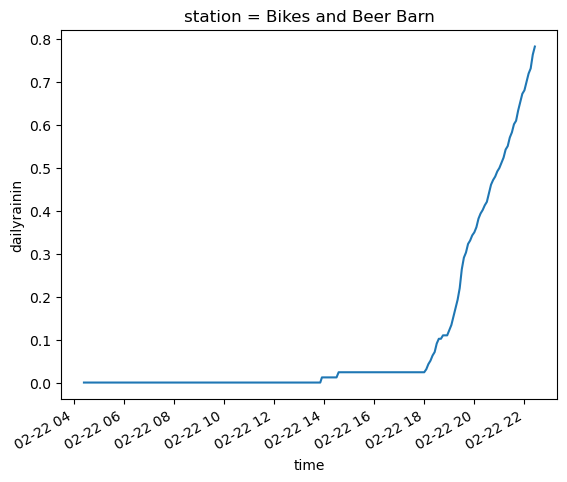

In [66]:

ds.dailyrainin.plot()

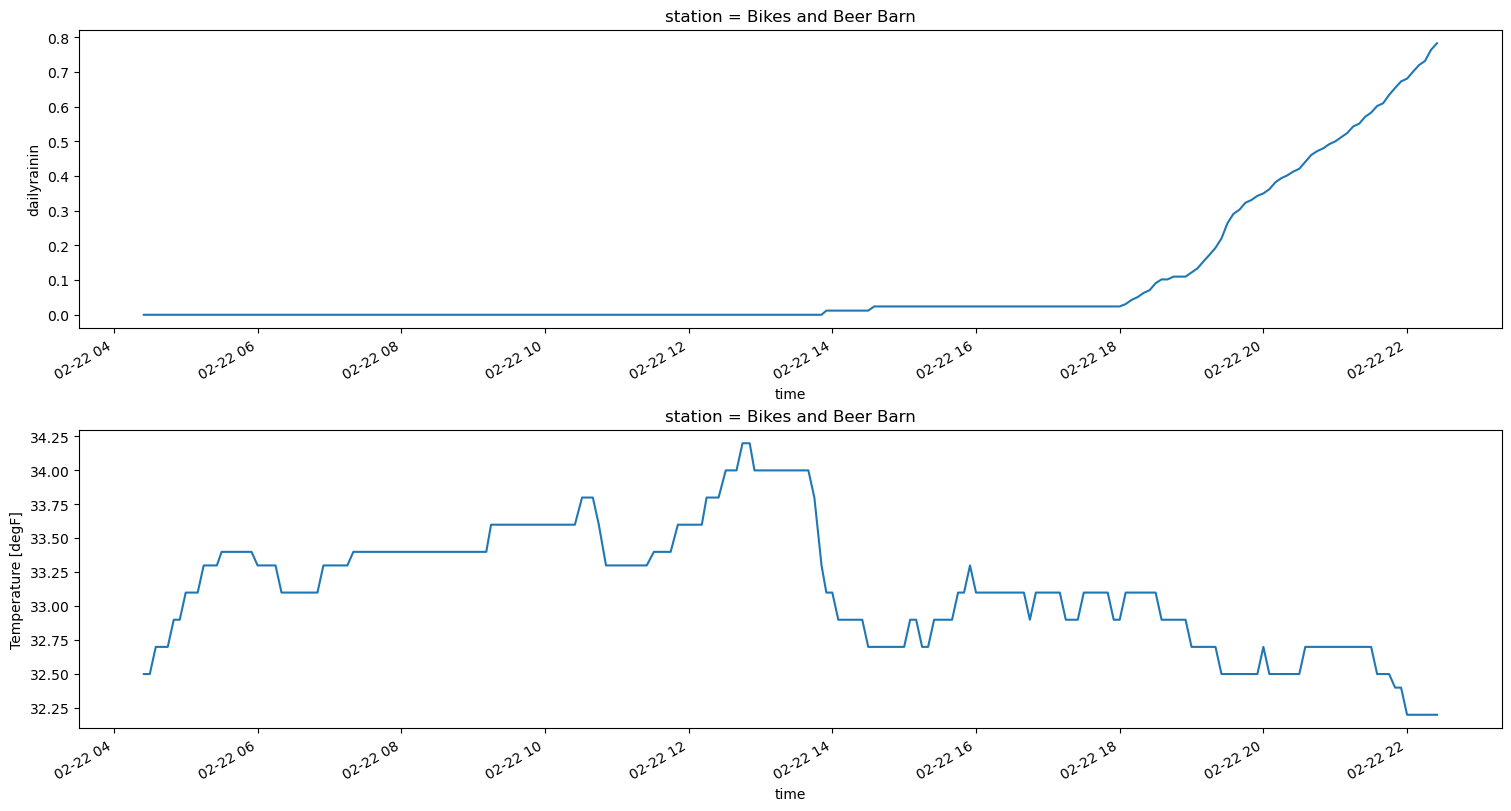

In [69]:
fig, axs = plt.subplots(ncols=1, nrows=2, constrained_layout=True, figsize=[15,8])
ds.dailyrainin.plot(ax=axs[0])
ds.outdoor_temperature.plot(ax=axs[1])



In [55]:
ds.outdoor_temperature

<xarray.DataArray 'outdoor_temperature' (station: 1, time: 217)>
array([[31.6, 31.5, 31.1, 30.9, 30.9, 31.1, 31.1, 31.5, 31.6, 31.8, 31.8,
        31.8, 32. , 32.2, 32.2, 32.2, 32.4, 32.4, 32.5, 32.5, 32.5, 32.5,
        32.5, 32.7, 32.7, 32.7, 32.9, 32.9, 33.1, 33.1, 33.1, 33.3, 33.3,
        33.3, 33.4, 33.4, 33.4, 33.4, 33.4, 33.4, 33.3, 33.3, 33.3, 33.3,
        33.1, 33.1, 33.1, 33.1, 33.1, 33.1, 33.1, 33.3, 33.3, 33.3, 33.3,
        33.3, 33.4, 33.4, 33.4, 33.4, 33.4, 33.4, 33.4, 33.4, 33.4, 33.4,
        33.4, 33.4, 33.4, 33.4, 33.4, 33.4, 33.4, 33.4, 33.4, 33.4, 33.4,
        33.4, 33.4, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.6,
        33.6, 33.6, 33.6, 33.6, 33.6, 33.6, 33.8, 33.8, 33.8, 33.6, 33.3,
        33.3, 33.3, 33.3, 33.3, 33.3, 33.3, 33.3, 33.4, 33.4, 33.4, 33.4,
        33.6, 33.6, 33.6, 33.6, 33.6, 33.8, 33.8, 33.8, 34. , 34. , 34. ,
        34.2, 34.2, 34. , 34. , 34. , 34. , 34. , 34. , 34. , 34. , 34. ,
        34. , 33.8, 33.3, 33.1, 33.1, 32.9, 32.9, 32.9, 32.9, 32.9, 32.7,
        32.7, 32.7, 32.7, 32.7, 32.7, 32.7, 32.9, 32.9, 32.7, 32.7, 32.9,
        32.9, 32.9, 32.9, 33.1, 33.1, 33.3, 33.1, 33.1, 33.1, 33.1, 33.1,
        33.1, 33.1, 33.1, 33.1, 32.9, 33.1, 33.1, 33.1, 33.1, 33.1, 32.9,
        32.9, 32.9, 33.1, 33.1, 33.1, 33.1, 33.1, 32.9, 32.9, 33.1, 33.1,
        33.1, 33.1, 33.1, 33.1, 32.9, 32.9, 32.9, 32.9, 32.9, 32.7, 32.7,
        32.7, 32.7, 32.7, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.7,
        32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.7, 32.7]])
Coordinates:
  * time     (time) datetime64[ns] 2023-02-22T02:40:00 ... 2023-02-22T20:40:00
  * station  (station) <U19 'Bikes and Beer Barn'
Attributes:
    standard_name:  Temperature
    units:          degF

In [43]:
api.api_key

'f759604cff504167adc5c5ca98ad5c00cc2b14e2362a4be88e52936fbaba1453'

In [73]:
ds.time

<xarray.DataArray 'time' (time: 217)>
array(['2023-02-22T04:30:00.000000000', '2023-02-22T04:35:00.000000000',
       '2023-02-22T04:40:00.000000000', ..., '2023-02-22T22:20:00.000000000',
       '2023-02-22T22:25:00.000000000', '2023-02-22T22:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-02-22T04:30:00 ... 2023-02-22T22:30:00

In [150]:
mytextfile = open('datame.txt')
lines = mytextfile.readlines()
mytextfile.close()

In [ ]:
lines

In [152]:
jsons = [json.loads(line) for line in lines]

In [153]:
jsons

[{'dateutc': 1677110220000,
  'tempinf': 73.6,
  'humidityin': 31,
  'baromrelin': 30.024,
  'baromabsin': 28.804,
  'tempf': 32.5,
  'battout': 1,
  'humidity': 98,
  'winddir': 18,
  'windspeedmph': 1.8,
  'windgustmph': 3.4,
  'maxdailygust': 14.8,
  'hourlyrainin': 0,
  'eventrainin': 0.929,
  'dailyrainin': 0.953,
  'weeklyrainin': 0.953,
  'monthlyrainin': 2.752,
  'totalrainin': 81.13,
  'solarradiation': 0,
  'uv': 0,
  'batt_co2': 1,
  'feelsLike': 32.5,
  'dewPoint': 32,
  'feelsLikein': 72.1,
  'dewPointin': 41.1,
  'lastRain': '2023-02-22T23:39:00.000Z',
  'tz': 'America/Chicago',
  'date': '2023-02-22T23:57:00.000Z',
  'macAddress': 'F4:CF:A2:7A:F1:BA'},
 {'dateutc': 1677110280000,
  'tempinf': 73.6,
  'humidityin': 31,
  'baromrelin': 30.024,
  'baromabsin': 28.804,
  'tempf': 32.5,
  'battout': 1,
  'humidity': 98,
  'winddir': 17,
  'windspeedmph': 4,
  'windgustmph': 8.1,
  'maxdailygust': 14.8,
  'hourlyrainin': 0,
  'eventrainin': 0.929,
  'dailyrainin': 0.953,
  'we

In [154]:
mac = '30:83:98:A5:AB:EC'
station1 = []
for jsone in jsons:
    if jsone['macAddress'] == '30:83:98:A5:AB:EC':
        station1.append(jsone)

In [155]:
station1

[{'dateutc': 1677110700000,
  'tempf': 33.1,
  'humidity': 96,
  'windspeedmph': 4.03,
  'windgustmph': 5.82,
  'maxdailygust': 20.58,
  'winddir': 69,
  'uv': 0,
  'solarradiation': 0,
  'hourlyrainin': 0,
  'eventrainin': 1.031,
  'dailyrainin': 1.039,
  'weeklyrainin': 1.039,
  'monthlyrainin': 2.87,
  'totalrainin': 7.571,
  'battout': 1,
  'tempinf': 58.3,
  'humidityin': 22,
  'baromrelin': 29.595,
  'baromabsin': 28.697,
  'pm25': 14,
  'pm25_24h': 16.3,
  'batt_25': 1,
  'feelsLike': 29.32,
  'dewPoint': 32.09,
  'feelsLikein': 58.3,
  'dewPointin': 19.6,
  'lastRain': '2023-02-22T23:30:00.000Z',
  'tz': 'America/Chicago',
  'date': '2023-02-23T00:05:00.000Z',
  'macAddress': '30:83:98:A5:AB:EC'},
 {'dateutc': 1677110760000,
  'tempf': 33.1,
  'humidity': 96,
  'windspeedmph': 7.16,
  'windgustmph': 8.05,
  'maxdailygust': 20.58,
  'winddir': 65,
  'uv': 0,
  'solarradiation': 0,
  'hourlyrainin': 0,
  'eventrainin': 1.031,
  'dailyrainin': 1.039,
  'weeklyrainin': 1.039,
  'mo

In [156]:
attrs_dict = {'tempf':{'standard_name': 'Temperature',
                       'units': 'degF'},
              'tempinf':{'standard_name': 'Temperature',
                         'units': 'degF'},
              'dewPoint': {'standard_name': 'Dewpoint Temperature',
                           'units': 'degF'},
              'dewPointin': {'standard_name': 'Dewpoint Temperature',
                             'units': 'degF'}}

variable_mapping = {'tempf':'outdoor_temperature',
                    'tempinf':'indoor_temperature',
                    'dewPoint':'outdoor_dewpoint',
                    'dewPointin':'indoor_dewpoint',
                    'date':'time'}

def process_data(ddat, attrs=attrs_dict, variable_mapping=variable_mapping):
    
    current_date = datetime.utcnow()
    # Read in the station data
    data = ddat
    
    #meta = device.info
    
    # Read into a pandas dataframe
    df = pd.DataFrame(data)
    
    # Format the times properly
    df['date'] = pd.to_datetime(df.date).astype('datetime64[ns]')

    # Sort the values and set the index to be the date
    df = df.sort_values('date')
    df = df.set_index('date')

    ds = df.to_xarray()

    # Add associated metadata
    for variable in attrs.keys():
        ds[variable].attrs = attrs[variable]
    
    # Rename the variables
    ds = ds.rename(variable_mapping)
        
    # Reshape the data
    #ds = ds.expand_dims('station')
    #ds['station'] = [meta['name']]
    #ds['latitude'] = meta['coords']['coords']['lat']
    #ds['longitude'] = meta['coords']['coords']['lon']
    
    ds = ds.sel(time=f"{current_date.year}-{current_date.month}-{current_date.day}")
    
    return ds

In [157]:
rtds = process_data(station1)

/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_46332/195849348.py:28: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df['date'] = pd.to_datetime(df.date).astype('datetime64[ns]')


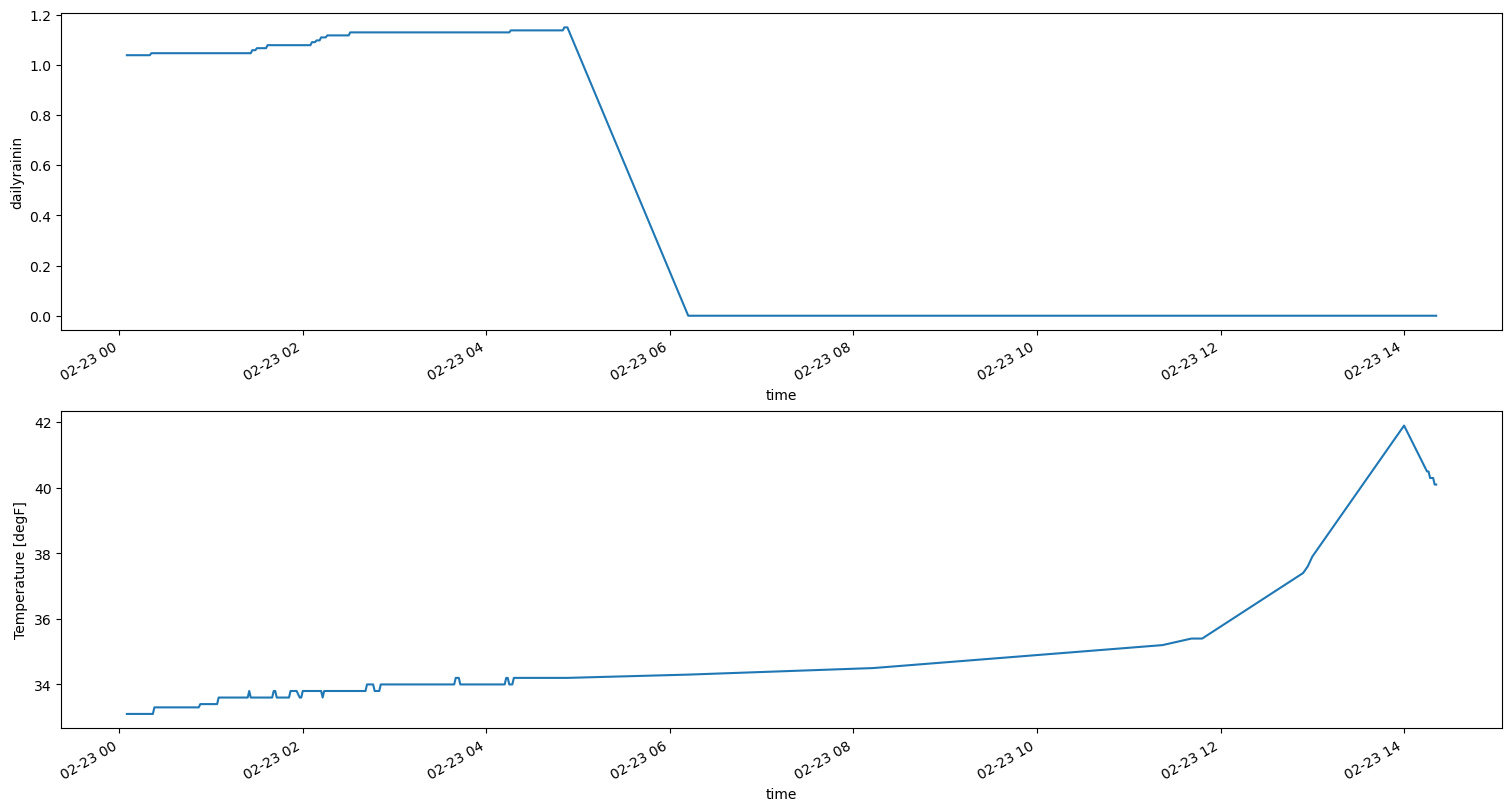

In [158]:
fig, axs = plt.subplots(ncols=1, nrows=2, constrained_layout=True, figsize=[15,8])
rtds.dailyrainin.plot(ax=axs[0])
rtds.outdoor_temperature.plot(ax=axs[1])


In [139]:
rtds.time

<xarray.DataArray 'time' (time: 129)>
array(['2023-02-23T00:05:00.000000000', '2023-02-23T00:06:00.000000000',
       '2023-02-23T00:07:00.000000000', '2023-02-23T00:08:00.000000000',
       '2023-02-23T00:09:00.000000000', '2023-02-23T00:10:00.000000000',
       '2023-02-23T00:11:00.000000000', '2023-02-23T00:12:00.000000000',
       '2023-02-23T00:13:00.000000000', '2023-02-23T00:14:00.000000000',
       '2023-02-23T00:15:00.000000000', '2023-02-23T00:16:00.000000000',
       '2023-02-23T00:17:00.000000000', '2023-02-23T00:18:00.000000000',
       '2023-02-23T00:19:00.000000000', '2023-02-23T00:20:00.000000000',
       '2023-02-23T00:21:00.000000000', '2023-02-23T00:22:00.000000000',
       '2023-02-23T00:23:00.000000000', '2023-02-23T00:24:00.000000000',
       '2023-02-23T00:25:00.000000000', '2023-02-23T00:26:00.000000000',
       '2023-02-23T00:27:00.000000000', '2023-02-23T00:28:00.000000000',
       '2023-02-23T00:29:00.000000000', '2023-02-23T00:30:00.000000000',
       '2023-02-23T00:31:00.000000000', '2023-02-23T00:32:00.000000000',
       '2023-02-23T00:33:00.000000000', '2023-02-23T00:34:00.000000000',
       '2023-02-23T00:35:00.000000000', '2023-02-23T00:36:00.000000000',
       '2023-02-23T00:37:00.000000000', '2023-02-23T00:38:00.000000000',
       '2023-02-23T00:39:00.000000000', '2023-02-23T00:40:00.000000000',
       '2023-02-23T00:41:00.000000000', '2023-02-23T00:42:00.000000000',
       '2023-02-23T00:43:00.000000000', '2023-02-23T00:44:00.000000000',
       '2023-02-23T00:45:00.000000000', '2023-02-23T00:46:00.000000000',
       '2023-02-23T00:47:00.000000000', '2023-02-23T00:48:00.000000000',
       '2023-02-23T00:49:00.000000000', '2023-02-23T00:50:00.000000000',
       '2023-02-23T00:51:00.000000000', '2023-02-23T00:52:00.000000000',
       '2023-02-23T00:53:00.000000000', '2023-02-23T00:54:00.000000000',
       '2023-02-23T00:55:00.000000000', '2023-02-23T00:57:00.000000000',
       '2023-02-23T00:58:00.000000000', '2023-02-23T00:59:00.000000000',
       '2023-02-23T01:00:00.000000000', '2023-02-23T01:01:00.000000000',
       '2023-02-23T01:02:00.000000000', '2023-02-23T01:03:00.000000000',
       '2023-02-23T01:04:00.000000000', '2023-02-23T01:05:00.000000000',
       '2023-02-23T01:06:00.000000000', '2023-02-23T01:07:00.000000000',
       '2023-02-23T01:08:00.000000000', '2023-02-23T01:09:00.000000000',
       '2023-02-23T01:10:00.000000000', '2023-02-23T01:11:00.000000000',
       '2023-02-23T01:12:00.000000000', '2023-02-23T01:13:00.000000000',
       '2023-02-23T01:14:00.000000000', '2023-02-23T01:15:00.000000000',
       '2023-02-23T01:16:00.000000000', '2023-02-23T01:17:00.000000000',
       '2023-02-23T01:18:00.000000000', '2023-02-23T01:19:00.000000000',
       '2023-02-23T01:20:00.000000000', '2023-02-23T01:21:00.000000000',
       '2023-02-23T01:22:00.000000000', '2023-02-23T01:23:00.000000000',
       '2023-02-23T01:24:00.000000000', '2023-02-23T01:25:00.000000000',
       '2023-02-23T01:26:00.000000000', '2023-02-23T01:27:00.000000000',
       '2023-02-23T01:28:00.000000000', '2023-02-23T01:29:00.000000000',
       '2023-02-23T01:30:00.000000000', '2023-02-23T01:31:00.000000000',
       '2023-02-23T01:32:00.000000000', '2023-02-23T01:33:00.000000000',
       '2023-02-23T01:34:00.000000000', '2023-02-23T01:35:00.000000000',
       '2023-02-23T01:36:00.000000000', '2023-02-23T01:37:00.000000000',
       '2023-02-23T01:38:00.000000000', '2023-02-23T01:39:00.000000000',
       '2023-02-23T01:40:00.000000000', '2023-02-23T01:41:00.000000000',
       '2023-02-23T01:42:00.000000000', '2023-02-23T01:43:00.000000000',
       '2023-02-23T01:44:00.000000000', '2023-02-23T01:45:00.000000000',
       '2023-02-23T01:46:00.000000000', '2023-02-23T01:47:00.000000000',
       '2023-02-23T01:48:00.000000000', '2023-02-23T01:49:00.000000000',
       '2023-02-23T01:50:00.000000000', '2023-02-23T01:51:00.000000000',
       '2023-02-23T01:52:00.000000000', '2023-02-23T01:53:00.000000000',
       '2023-02-23T0